Initial data processing and cleaning:

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
#from skopt import BayesSearchCV
from xgboost import XGBClassifier


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = train.dropna()
test = test.dropna()

X_test = test.drop(test.columns[0], axis=1)
X_train = train.drop(train.columns[11], axis=1)
Y_train = (train.iloc[:, -1] == 'High').astype(int)

def clean_and_normalize(data):
  date_name = 'track_album_release_date'
  #to remove date/time just delete idx 9 from this list
  columns_to_keep = [0, 1, 2, 3, 4, 6, 9, 11, 12, 13, 14, 15, 16, 17]
  data = data.iloc[:, columns_to_keep].copy()
  data[date_name] = pd.to_datetime(data[date_name], errors='coerce')
  most_common_date = data[date_name].mode()[0]
  data[date_name] = data[date_name].fillna(most_common_date)
  today = pd.to_datetime('today')
  data[date_name] = (today - data[date_name]).dt.days
  return data

X_train = clean_and_normalize(X_train)
X_test = clean_and_normalize(X_test)
print(X_train.head())
print(X_test.head())
print(Y_train.head())

X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

   time_signature  speechiness  danceability  duration_ms  energy  mode  \
0             4.0       0.2040         0.882     140733.0   0.764   1.0   
1             4.0       0.1590         0.779     246960.0   0.640   1.0   
2             4.0       0.2230         0.770     189707.0   0.597   1.0   
3             5.0       0.3210         0.573     172296.0   0.693   1.0   
4             4.0       0.0315         0.714     274488.0   0.720   1.0   

   track_album_release_date  instrumentalness  valence   key    tempo  \
0                       268          0.000000    0.886  11.0  140.113   
1                      7110          0.000766    0.499   7.0   99.017   
2                       239          0.000000    0.875   1.0  170.022   
3                        99          0.004240    0.837   6.0  150.850   
4                      1514          0.000000    0.696   6.0  113.015   

   loudness  acousticness  liveness  
0    -5.241      0.359000    0.1190  
1    -8.415      0.000155    0.101

Heat map showing correlation between features:

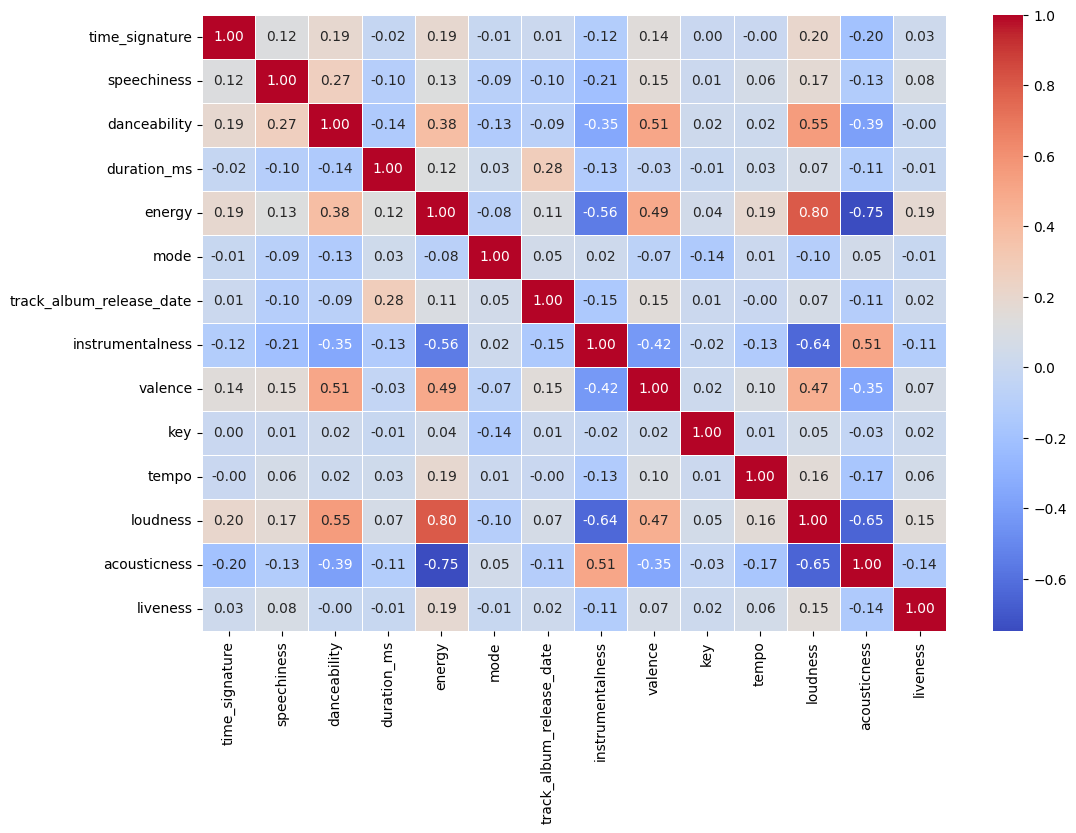

In [5]:
correlation_matrix = X_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

Feature importance visualization based on random forest classifier:

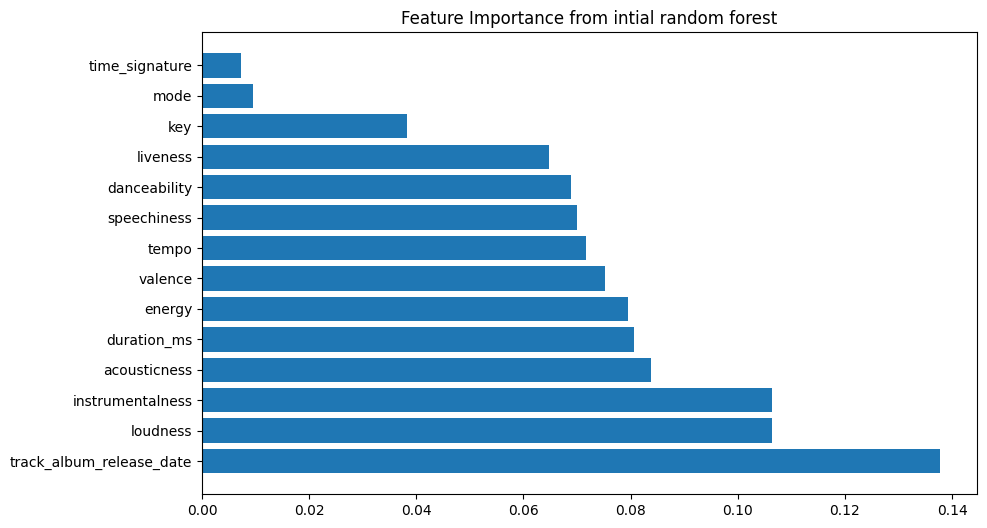

In [6]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt')
rf.fit(X_train, Y_train)
rf_features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})

rf_features = rf_features.sort_values(by='Importance', ascending=False)

select_rf = [i for i, importance in enumerate(rf.feature_importances_) if importance > 0.05]

# plotting
plt.figure(figsize=(10, 6))
plt.barh(rf_features['Feature'], rf_features['Importance'])
plt.title('Feature Importance from intial random forest')
plt.show()

More feature importance analysis with mutual information classifier:

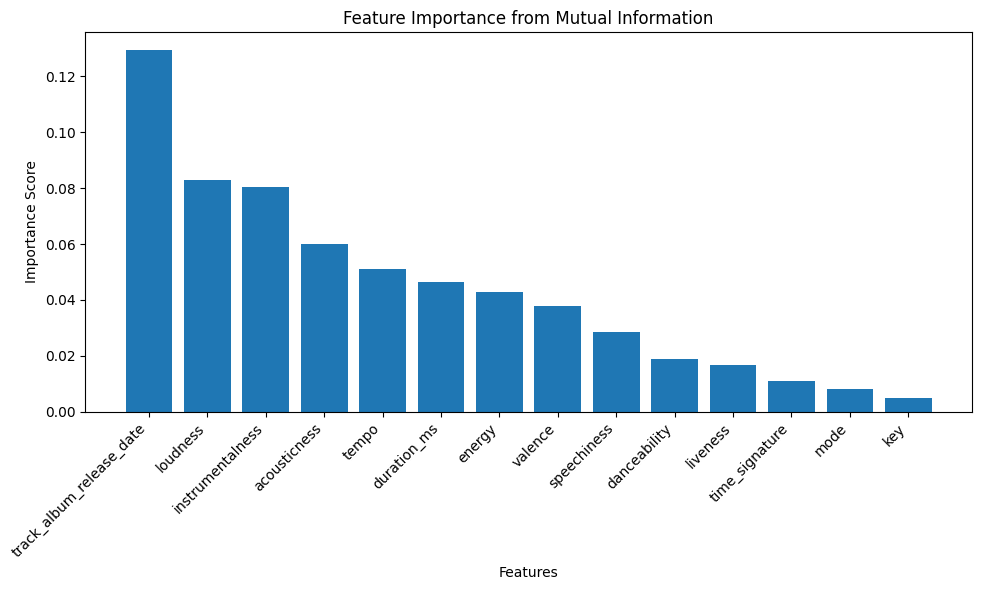

In [7]:
importance = mutual_info_classif(X_train, Y_train)
select_mi = [i for i, score in enumerate(importance) if score > 0.035]
feature_names = X_train.columns

sorted_indices = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_indices]
sorted_features = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features)
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance from Mutual Information")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

Best performing model (0.83342 score):

In [8]:
!pip install scikit-optimize
from skopt import BayesSearchCV
X_train_selected = X_train.iloc[:, select_rf]
X_val_selected = X_val.iloc[:, select_rf]

xgb = XGBClassifier(random_state=42, eval_metric='auc')

param_space = {
    'n_estimators': (100, 1500),
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'subsample': (0.4, 0.9),
    'colsample_bytree': (0.3, 1.0),
    'gamma': (0.0, 5.0),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.5, 1.0)
}

bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=True
)

bayes_search.fit(X_train_selected, Y_train)

print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Accuracy:", bayes_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
X_test_selected = X_test.iloc[:, select_rf]
y_pred = bayes_search.predict_proba(X_test_selected)[:, 1]
print(y_pred)
submission = pd.DataFrame({"ID": test["ID"], "Popularity_Type": y_pred})
submission.to_csv("submission11.csv", index=False)

Below includes some additional data exploration and feature engineering that we completed throughout the course of this project. While they are not directly related to our final model shown above, we thought that they would be interesting to share.

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = train.dropna()
test = test.dropna()

X_test = test.drop(test.columns[0], axis=1)
X_train = train.drop(train.columns[11], axis=1)
Y_train = (train.iloc[:, -1] == 'High').astype(int)

print(X_train.head())
print(X_test.head())
print(Y_train.head())

   time_signature  speechiness  danceability  duration_ms  energy  \
0             4.0       0.2040         0.882     140733.0   0.764   
1             4.0       0.1590         0.779     246960.0   0.640   
2             4.0       0.2230         0.770     189707.0   0.597   
3             5.0       0.3210         0.573     172296.0   0.693   
4             4.0       0.0315         0.714     274488.0   0.720   

                                          track_href  mode  \
0  https://api.spotify.com/v1/tracks/7iabz12vAuVQ...   1.0   
1  https://api.spotify.com/v1/tracks/4TsmezEQVSZN...   1.0   
2  https://api.spotify.com/v1/tracks/1AtFSBJibfaq...   1.0   
3  https://api.spotify.com/v1/tracks/18Crh1Nd55lR...   1.0   
4  https://api.spotify.com/v1/tracks/42Xxh6RlXeZU...   1.0   

                                    uri            type  \
0  spotify:track:7iabz12vAuVQYyekFIWJxD  audio_features   
1  spotify:track:4TsmezEQVSZNNPv5RJ65Ov  audio_features   
2  spotify:track:1AtFSBJibfaqfiOByQ

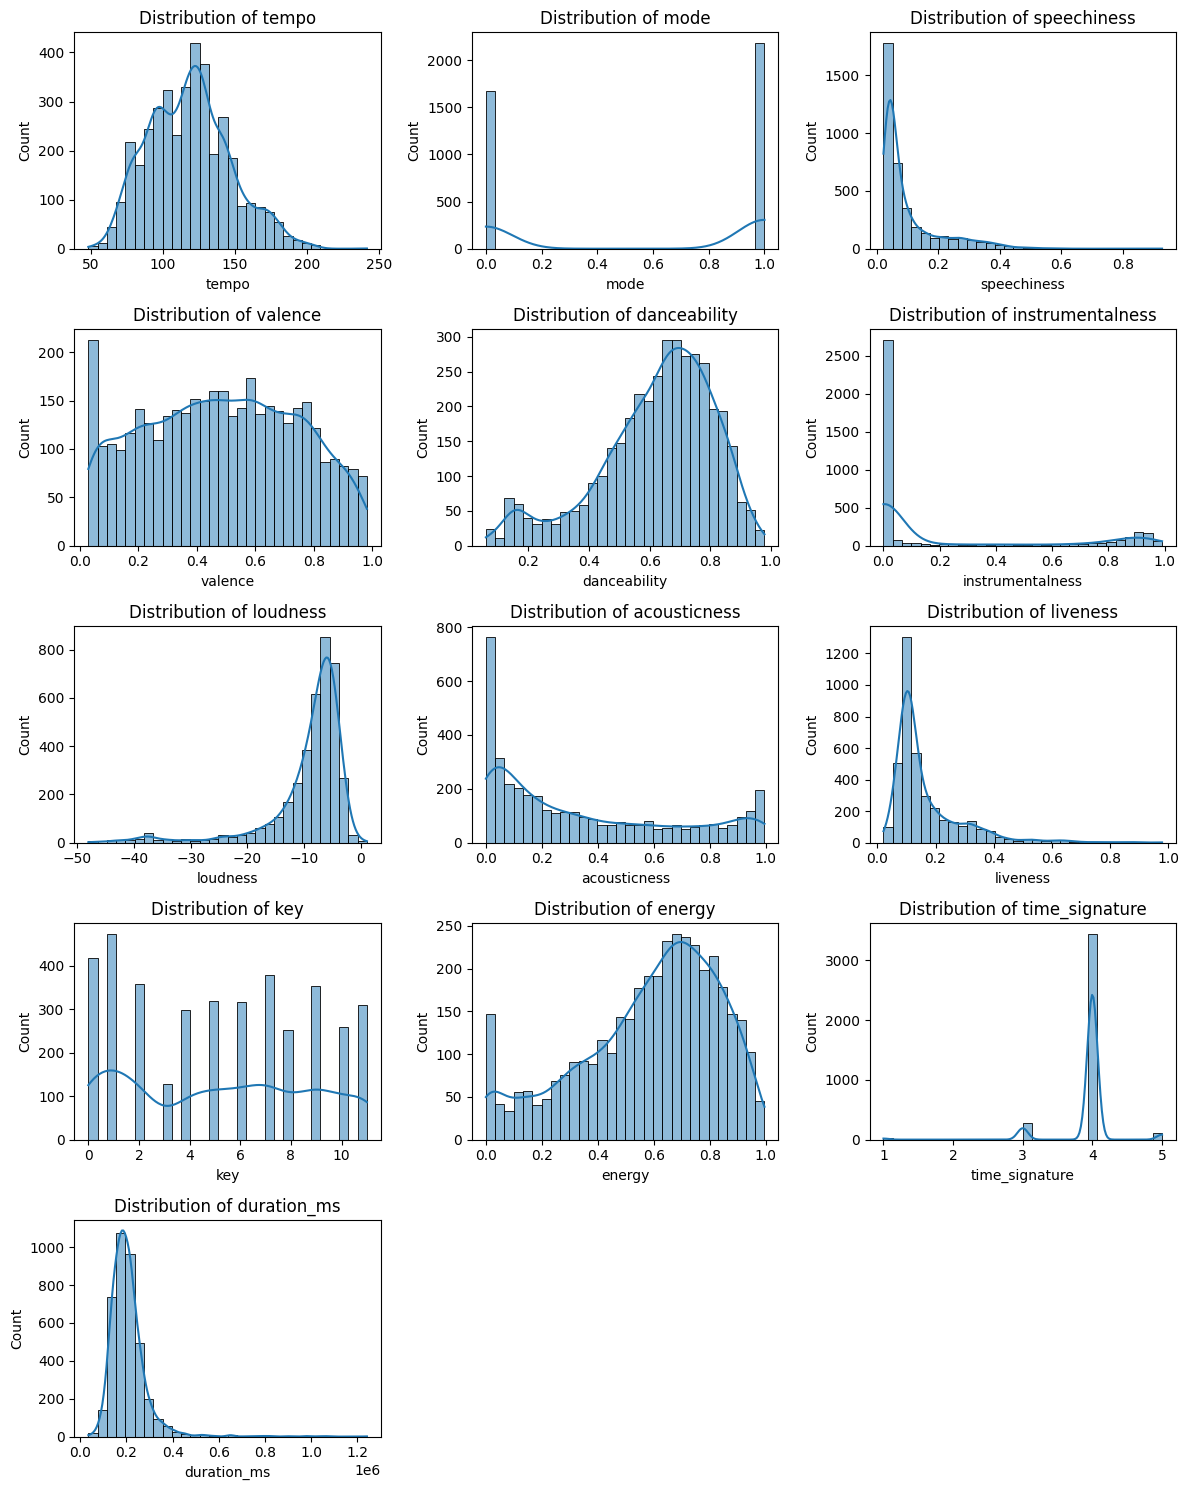

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numeric_features = list(set([
    'liveness', 'mode', 'energy', 'duration_ms', 'danceability', 'speechiness',
    'time_signature', 'key', 'instrumentalness', 'valence', 'tempo',
    'loudness', 'acousticness'
]))

X_train_filtered = X_train[numeric_features].replace([np.inf, -np.inf], np.nan)
X_train_filtered = X_train_filtered.fillna(X_train_filtered.median())

num_features = len(numeric_features)
num_rows = (num_features // 3) + (num_features % 3 > 0)

plt.figure(figsize=(12, num_rows * 3))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(X_train_filtered[feature], bins=30, kde=True)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()


Normalized specific features based on their extreme right and left skew, using log transformations and standardized normalization for specific right and left skews.

In [ ]:
import numpy as np

skewed_features = ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms']

for feature in skewed_features:
    X_train[feature] = np.log1p(X_train[feature])
    X_test[feature] = np.log1p(X_test[feature])

X_train['loudness'] = (X_train['loudness'] - X_train['loudness'].mean()) / X_train['loudness'].std()
X_test['loudness'] = (X_test['loudness'] - X_test['loudness'].mean()) / X_test['loudness'].std()


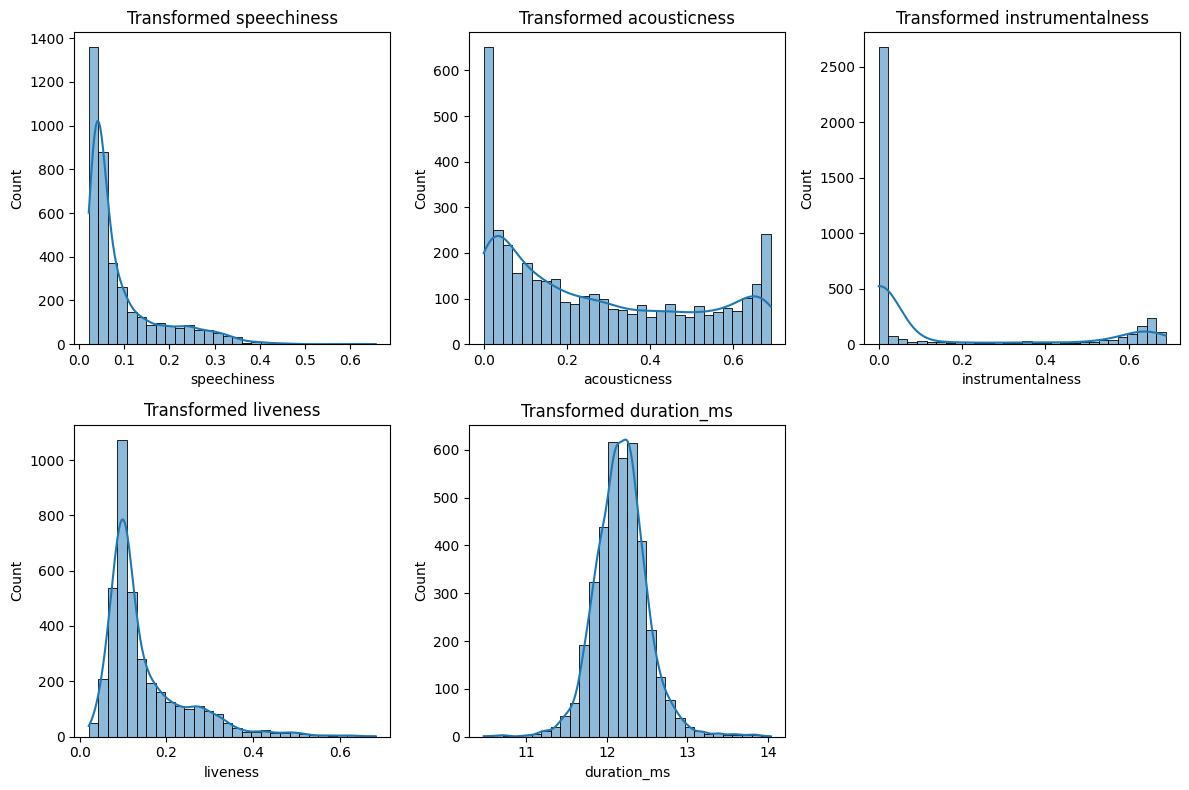

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
for i, feature in enumerate(skewed_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(X_train[feature], bins=30, kde=True)
    plt.title(f"Transformed {feature}")
plt.tight_layout()
plt.show()

Created new feature showing age of specific tracks to convert this column into a usable feature.

In [ ]:
X_train['track_album_release_date'] = pd.to_datetime(X_train['track_album_release_date'], errors='coerce')
X_test['track_album_release_date'] = pd.to_datetime(X_test['track_album_release_date'], errors='coerce')


X_train['track_age'] = 2025 - X_train['track_album_release_date'].dt.year
X_test['track_age'] = 2025 - X_test['track_album_release_date'].dt.year


In [ ]:
X_train = X_train.drop(columns=['track_album_release_date', 'track_href', 'uri', 'type', 'analysis_url'])
X_test = X_test.drop(columns=['track_album_release_date', 'track_href', 'uri', 'type', 'analysis_url'])

In [ ]:
if 'Popularity_Type' in X_train.columns:
    X_train = X_train.drop(columns=['Popularity_Type'])

if 'Popularity_Type' in X_test.columns:
    X_test = X_test.drop(columns=['Popularity_Type'])

Plotted correlations of finalized normalized and new features with popularity type.


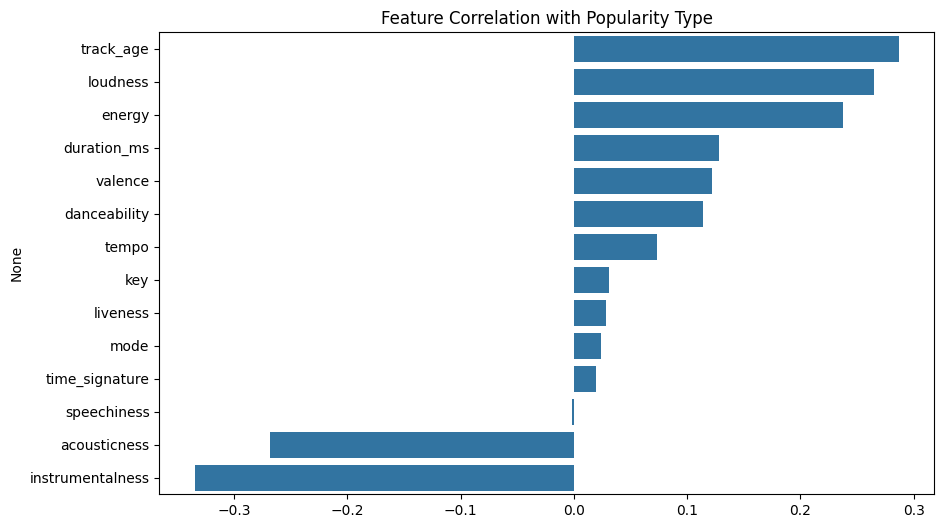

track_age           0.287119
loudness            0.265299
energy              0.237389
duration_ms         0.127787
valence             0.121955
danceability        0.113841
tempo               0.073331
key                 0.031071
liveness            0.028177
mode                0.023643
time_signature      0.019537
speechiness        -0.001506
acousticness       -0.268036
instrumentalness   -0.334855
dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation = X_train.corrwith(Y_train).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=correlation.values, y=correlation.index)
plt.title("Feature Correlation with Popularity Type")
plt.show()

print(correlation)
